In [2]:
from torch import empty
from torch.random import manual_seed
from matplotlib import pyplot as plt

import lamp as l
from data import generate_data
from helpers import optimize, compute_accuracy, pickle_dump, pickle_load

manual_seed(42)

%load_ext autoreload
%autoreload 2

In [3]:
num_samples=1000
epochs=100
train_data, test_data = generate_data(num_samples)

In [4]:
input_dim = 2
output_dim = 1
nb_hidden = 25
model = l.Sequential(
    l.Linear(input_dim, nb_hidden),
    l.Tanh(),
    l.Linear(nb_hidden),
    l.Tanh(),
    l.Linear(nb_hidden),
    l.Tanh(),
    l.Linear(nb_hidden, output_dim),
    l.Sigmoid()
)

## Parameter tuning

In [5]:
def tune_model(model):    
    learning_rates = 0.01 * 2**np.arange(8)
    batch_sizes = [1, 10, 25, 50, 100, 200, 500, num_samples]

    results = []
    for batch_size in batch_sizes:
        best_loss = best_learning_rate = best_batch_losses = None
        for learning_rate in learning_rates:
            batch_losses, train_losses, test_losses = optimize(
                model,
                train_data,
                test_data,
                epochs=epochs,
                batch_size=batch_size,
                lr=learning_rate,
                verbose=False
            )
            best_loss_achieved = test_losses.min().item()
            if best_loss is None or best_loss_achieved < best_loss:
                best_loss = best_loss_achieved
                best_learning_rate = learning_rate
                best_batch_losses = batch_losses
                best_test_losses = test_losses
                best_train_losses = train_losses
        results.append((batch_size, best_learning_rate, best_batch_losses, best_test_losses, best_train_losses))
    return results

In [6]:
filename = 'results'
try:
    results = pickle_load(filename)
except FileNotFoundError:
    results = tune_model(model)
    pickle_dump(filename, results)

In [7]:
def best_so_far(tensor):
    ndarr = tensor.numpy()
    for i, el in enumerate(ndarr):
        if i > 0 and ndarr[i-1] < ndarr[i]:
            ndarr[i] = ndarr[i-1]
    return ndarr

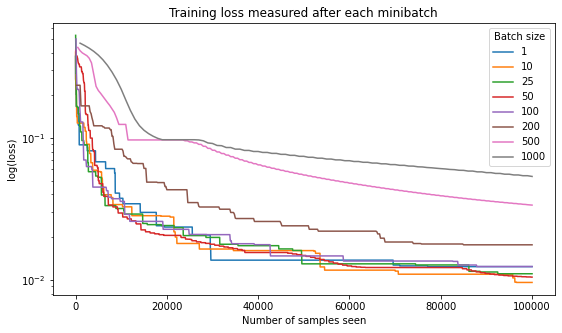

In [8]:
fig, ax = plt.subplots(figsize=(9, 5))
plt.yscale('log') 
for batch_size, lr, batch_losses, _, _ in results:
    x = range(batch_size, batch_size * len(batch_losses) + batch_size, batch_size)
    ax.plot(x, best_so_far(batch_losses), label = batch_size)

plt.title('Training loss measured after each minibatch')
plt.xlabel('Number of samples seen')
plt.ylabel('log(loss)')
plt.legend(title='Batch size');
plt.savefig('plots/loss-per-minibatch');

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))
plt.yscale('log') 
for batch_size, lr, _, _, train_losses in results:
    N = num_samples
    x = range(N, epochs * N + N, N)
    ax.plot(x, best_so_far(train_losses), label = batch_size)

plt.title('Training loss measured after each epoch')
plt.xlabel('Number of samples seen')
plt.ylabel('log(loss)')
plt.legend(title='Batch size')
plt.savefig('plots/loss-per-epoch');

## Measuring the effectiveness of shuffling

In [ ]:
filename = 'shuffle-experiment-accuracy'
try:
    accuracies = pickle_load(filename)
except FileNotFoundError:
    batch_size = 50
    lr = 0.16

    num_iters = 50

    accuracies = {
        True: [],
        False: []
    }
    for shuffle in [True, False]:
        for i in range(num_iters):
            print(f'Shuffle: {shuffle} - Iteration: {i}')
            optimize(model, train_data, test_data, epochs=epochs, batch_size=batch_size, lr=lr, shuffle=shuffle, verbose=False)
            accuracy, _, _ = compute_accuracy(model, *test_data)
            accuracy = round(accuracy.item(), 3)
            accuracies[shuffle].append(accuracy)

    pickle_dump(filename, accuracies)

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(accuracies.values(), labels=['Shuffled', 'Non-shuffled'])
plt.savefig('plots/effectiveness-of-shuffling');